# Load data

In [1]:
import re
import os
import random
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

import tensorflow as tf
import tensorflow.keras as K
import keras_tuner as kt

from utils import (
    normalize_mid_points,
    read_data
)

In [105]:
keypoints = os.listdir('../data/keypoints')

# punch types: hook, jab, uper
keypoints_by_punch_types = [
    [i for i in keypoints if 'hook' in i],
    [i for i in keypoints if 'jab' in i],
    [i for i in keypoints if 'uper' in i]
]

In [106]:
X_train_list = []
y_train_list = []
X_val_list = []
y_val_list = []

for keypoints in keypoints_by_punch_types:
    test_keypoints = random.choice(keypoints)

    for label in [i for i in keypoints if i != test_keypoints]:
        X, y = read_data(label, skip_midpoints=False)
        X_train_list.append(X)
        y_train_list.append(y)
    
    X, y = read_data(test_keypoints, skip_midpoints=False)
    X_val_list.append(X)
    y_val_list.append(y)


X_train = np.concatenate(X_train_list)
y_train = np.concatenate(y_train_list)
X_val = np.concatenate(X_val_list)
y_val = np.concatenate(y_val_list)

id4_hook_1|reversed: False|data shape: (1054, 36)
--------------------
id1_hook_2|reversed: False|data shape: (792, 36)
--------------------
id0_hook_2|reversed: True|data shape: (1051, 36)
--------------------
id0_hook_2|reversed: False|data shape: (1051, 36)
--------------------
id4_hook_2|reversed: False|data shape: (1059, 36)
--------------------
id1_hook_2|reversed: True|data shape: (792, 36)
--------------------
id2_hook_2|reversed: False|data shape: (1041, 36)
--------------------
id1_hook_1|reversed: False|data shape: (858, 36)
--------------------
id3_hook_2|reversed: False|data shape: (1297, 36)
--------------------
id4_hook_2|reversed: True|data shape: (1059, 36)
--------------------
id0_hook_1|reversed: False|data shape: (1100, 36)
--------------------
id2_hook_1|reversed: False|data shape: (1013, 36)
--------------------
id3_hook_2|reversed: True|data shape: (1297, 36)
--------------------
id2_hook_2|reversed: True|data shape: (1041, 36)
--------------------
id3_hook_1|rev

In [107]:
X_train.shape, y_train.shape, X_val.shape, y_val.shape

((42690, 36), (42690,), (3693, 36), (3693,))

In [108]:
time_steps=30 # expect camera 30 fps, so process 1 sample per second

# Number of samples in batch
N_train = X_train.shape[0] // time_steps 
N_val = X_val.shape[0] // time_steps

X_train = X_train[:N_train*time_steps].reshape(-1, time_steps, 36)
y_train = y_train[:N_train*time_steps].reshape(-1, time_steps, 1)
X_val = X_val[:N_val*time_steps].reshape(-1, time_steps, 36)
y_val = y_val[:N_val*time_steps].reshape(-1, time_steps, 1)
X_train.shape, X_val.shape

((1423, 30, 36), (123, 30, 36))

## CNN

In [109]:
y_train = K.utils.to_categorical(y_train, num_classes=7)
X_train = tf.constant(X_train)
y_val = K.utils.to_categorical(y_val, num_classes=7)
X_val = tf.constant(X_val)

In [110]:
X_dev = tf.expand_dims(X_train[:32], -1)
y_dev = y_train[:32]

X_dev.shape, y_dev.shape

(TensorShape([32, 30, 36, 1]), (32, 30, 7))

In [198]:
def model_builder(hp):
    # Hyperparams
    hp_pad = hp.Int('padding', min_value=1, max_value=4)
    hp_filters1 = hp.Int('filters1', min_value=16, max_value=128, step=8)
    hp_filters2 = hp.Int('filters2', min_value=16, max_value=128, step=8)
    hp_hidden_units = hp.Int('units', min_value=16, max_value=128, step=8)

    hp_learning_rate = hp.Float('learning_rate', min_value=1e-4, max_value=1e-2)

    pad_1 = tf.constant([[0,0], [hp_pad, hp_pad], [0,0], [0,0]])
    
    inputs = K.Input(shape=(30, 36, 1))
    # x = tf.keras.layers.LayerNormalization(axis=-2)(inputs)
    
    x = tf.pad(inputs, pad_1, 'CONSTANT')
    x = K.layers.Conv2D(filters=hp_filters1, kernel_size=(1+hp_pad*2, 36))(x)
    x = tf.squeeze(x, axis=-2)
    
    pad_2 = tf.constant([[0,0], [1,1], [0,0]])
    x = tf.pad(x, pad_2, 'CONSTANT')
    x = K.layers.Conv1D(filters=hp_filters2, kernel_size=3)(x)
    
    x = K.layers.Dense(hp_hidden_units, activation='relu')(x)
    
    out = K.layers.Dense(7, activation='softmax')(x)

    model = K.Model(inputs=inputs, outputs=out, name="cnn_model")

    model.compile(optimizer=K.optimizers.Adam(hp_learning_rate),
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
    return model

In [193]:
pad_1 = tf.constant([[0,0], [1,1], [0,0], [0,0]])

inputs = K.Input(shape=(30, 36, 1))
x = tf.keras.layers.LayerNormalization(axis=-2)(inputs)
x = tf.pad(inputs, pad_1, 'CONSTANT')
x = K.layers.Conv2D(filters=64, kernel_size=(3, 36))(x)
x = tf.squeeze(x, axis=-2)
pad_2 = tf.constant([[0,0], [1,1], [0,0]])
x = tf.pad(x, pad_2, 'CONSTANT')
x = K.layers.Conv1D(filters=128, kernel_size=3)(x)
x = K.layers.Dense(24, activation='relu')(x)
out = K.layers.Dense(7, activation='softmax')(x)
 
model = K.Model(inputs=inputs, outputs=out, name="cnn_model")

model.compile(optimizer=K.optimizers.Adam(),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

<KerasTensor: shape=(None, 30, 128) dtype=float32 (created by layer 'conv1d_11')>

In [200]:
tuner = kt.Hyperband(model_builder,
                     objective='val_accuracy',
                     max_epochs=20,
                     directory='kt_dir2',
                     project_name='punch_dl_kt')

stop_early = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=8)

tuner.search(X_train, y_train, batch_size=4, validation_data=(X_val, y_val), 
             epochs=32, callbacks=[stop_early])

Trial 31 Complete [00h 00m 16s]
val_accuracy: 0.6108400821685791

Best val_accuracy So Far: 0.6414633989334106
Total elapsed time: 00h 03m 04s
INFO:tensorflow:Oracle triggered exit


In [202]:
# Get the optimal hyperparameters
best_hps=tuner.get_best_hyperparameters(num_trials=1)[0]

best_hps.values

{'padding': 4,
 'filters1': 112,
 'filters2': 32,
 'units': 104,
 'learning_rate': 0.000961143157312793,
 'tuner/epochs': 20,
 'tuner/initial_epoch': 7,
 'tuner/bracket': 2,
 'tuner/round': 2,
 'tuner/trial_id': '0f513c5f10cf45d5611fff7d408533b5'}

In [203]:
# Build the model with the optimal hyperparameters and train it on the data for 64 epochs
model = tuner.hypermodel.build(best_hps)
history = model.fit(X_train, y_train, batch_size=1, 
                    validation_data=(X_val, y_val), 
                    epochs=64,
                   callbacks=[K.callbacks.ReduceLROnPlateau()])

val_acc_per_epoch = history.history['val_accuracy']
best_epoch = val_acc_per_epoch.index(max(val_acc_per_epoch)) + 1
print('Best epoch: %d' % (best_epoch,))

Epoch 1/64
1423/1423 [==============================] - 3s 2ms/step - loss: 1.4261 - accuracy: 0.5002 - val_loss: 1.3273 - val_accuracy: 0.5295
Epoch 2/64
1423/1423 [==============================] - 2s 2ms/step - loss: 1.2150 - accuracy: 0.5677 - val_loss: 1.1762 - val_accuracy: 0.6138
Epoch 3/64
1423/1423 [==============================] - 2s 2ms/step - loss: 1.1005 - accuracy: 0.6013 - val_loss: 1.1054 - val_accuracy: 0.5748
Epoch 4/64
1423/1423 [==============================] - 2s 2ms/step - loss: 1.0293 - accuracy: 0.6186 - val_loss: 1.0120 - val_accuracy: 0.5970
Epoch 5/64
1423/1423 [==============================] - 2s 2ms/step - loss: 0.9897 - accuracy: 0.6258 - val_loss: 1.0686 - val_accuracy: 0.5886
Epoch 6/64
1423/1423 [==============================] - 2s 2ms/step - loss: 0.9632 - accuracy: 0.6402 - val_loss: 1.0212 - val_accuracy: 0.6198
Epoch 7/64
1423/1423 [==============================] - 2s 2ms/step - loss: 0.9282 - accuracy: 0.6483 - val_loss: 1.1572 - val_accuracy:

1423/1423 [==============================] - 2s 2ms/step - loss: 0.3412 - accuracy: 0.8773 - val_loss: 0.8477 - val_accuracy: 0.7190
Epoch 58/64
1423/1423 [==============================] - 2s 2ms/step - loss: 0.3412 - accuracy: 0.8772 - val_loss: 0.8479 - val_accuracy: 0.7190
Epoch 59/64
1423/1423 [==============================] - 2s 2ms/step - loss: 0.3412 - accuracy: 0.8772 - val_loss: 0.8480 - val_accuracy: 0.7184
Epoch 60/64
1423/1423 [==============================] - 2s 2ms/step - loss: 0.3409 - accuracy: 0.8772 - val_loss: 0.8481 - val_accuracy: 0.7184
Epoch 61/64
1423/1423 [==============================] - 2s 2ms/step - loss: 0.3409 - accuracy: 0.8772 - val_loss: 0.8482 - val_accuracy: 0.7184
Epoch 62/64
1423/1423 [==============================] - 2s 2ms/step - loss: 0.3409 - accuracy: 0.8772 - val_loss: 0.8482 - val_accuracy: 0.7184
Epoch 63/64
1423/1423 [==============================] - 2s 2ms/step - loss: 0.3409 - accuracy: 0.8773 - val_loss: 0.8483 - val_accuracy: 0.71

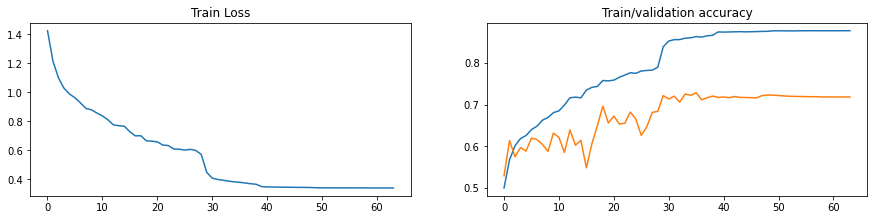

In [204]:
plt.figure(figsize=(15, 7))
plt.subplot(221)
plt.title("Train Loss")
plt.plot(history.history['loss'])
plt.subplot(222)
plt.title("Train/validation accuracy")
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])